In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyvi import ViTokenizer
import re
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/data/News/data VN/vntoken.xlsx")

In [ ]:
data.head()

,URL,Title,Summary,Contents,Date,Author(s),Category,Tags
0,https://laodong.vn/ban-doc/cach-tham-gia-bao-h...,Cách tham gia Bảo hiểm xã hội tự nguyện sau kh...,Bảo hiểm xã hội Việt Nam thông tin về mức đóng...,Bạn đọc hỏi: Tôi mới đi làm và tham gia Bảo hi...,"Thứ tư, 22/09/2021 10:00 (GMT+7)",ANH THƯ,Bạn đọc,"['Bảo hiểm xã hội', 'Bảo hiểm xã hội Việt Nam'..."
1,https://laodong.vn/ban-doc/quang-tri-cay-co-da...,Quảng Trị: Cây cọ dầu ở nơi có dự án của Vingr...,Quảng Trị - Ở địa điểm xây dựng khu đô thị thư...,"Sau khi đấu giá trúng khu đất rộng 132.415,6 m...","Thứ tư, 09/03/2022 18:13 (GMT+7)",HƯNG THƠ,Bạn đọc,"['Quảng Trị', 'Dự án Vingroup ở Quảng Trị', 'V..."
2,https://laodong.vn/ban-doc/lao-cai-dan-khat-nu...,Lào Cai: Dân khát nước bên công trình nước sạc...,Lào Cai – Hàng trăm hộ dân vẫn phải dùng nước ...,"Phản ánh đến PV, người dân xã Cam Đường, TP.Là...","Thứ tư, 11/05/2022 16:57 (GMT+7)",Văn Đức,Bạn đọc,"['Lào Cai', 'Nước sạch', 'nhà máy nước sạch', ..."
3,https://laodong.vn/ban-doc/quy-dinh-ve-viec-la...,Quy định về việc làm giám định sức khoẻ để ngh...,Bạn đọc Hà My hỏi: Tôi có làm giám định sức kh...,"Về vấn đề trên, Bảo hiểm xã hội Việt Nam trả l...","Chủ nhật, 20/06/2021 20:16 (GMT+7)",Minh Hương,Bạn đọc,"['Bảo hiểm xã hội', 'Luật Bảo hiểm xã hội', 'N..."
4,https://laodong.vn/ban-doc/iphone-12-va-dang-c...,iPhone 12 và đẳng cấp “móc túi” người dùng của...,Âm thầm tăng giá bán nhưng lại giảm phụ kiện đ...,"Nếu là iFan, hẳn các bạn còn nhớ, ngày 11.9.20...","Thứ năm, 15/10/2020 06:58 (GMT+7)",Đạt Phan,Bạn đọc,"['Bảo vệ môi trường', 'Apple', 'Iphone', 'Appl..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39000 entries, 0 to 38999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   URL        39000 non-null  object
 1   Title      39000 non-null  object
 2   Summary    38413 non-null  object
 3   Contents   36961 non-null  object
 4   Date       39000 non-null  object
 5   Author(s)  38234 non-null  object
 6   Category   39000 non-null  object
 7   Tags       39000 non-null  object
dtypes: object(8)
memory usage: 2.4+ MB


In [ ]:
data.shape

(39000, 8)

In [ ]:
num_categories = data['Category'].nunique()
print(f'Số lượng thể loại có trong bộ dữ liệu: {num_categories}')

Số lượng thể loại có trong bộ dữ liệu: 39


In [ ]:
# # Tải bộ stop word Tiếng Việt
# !gdown 1NHM08W6U9xkf2ajuotD6QWQBBSvp5jj6

In [ ]:

# Kiểm tra các giá trị trùng lặp và các dòng bị thiếu dữ liệu
print('Giá trị trùng lặp:',data.duplicated().sum())
print("\nGiá trị bị thiếu:")
data.isnull().sum()

Giá trị trùng lặp: 20687

Giá trị bị thiếu:


URL             0
Title           0
Summary       587
Contents     2039
Date            0
Author(s)     766
Category        0
Tags            0
dtype: int64

In [ ]:

# Xoá các dòng chứa giá trị trùng lặp và các dòng bị thiếu dữ liệu
data.drop_duplicates(inplace = True)
data.dropna(inplace = True)
data.reset_index(drop = True, inplace = True)


In [ ]:
print('\nSố lượng bài viết của từng thể loại:')
category_counts = data['Category'].value_counts()
category_counts



Số lượng bài viết của từng thể loại:


Pháp luật                     985
Thế giới                      975
Kinh doanh                    966
Thể thao                      965
Xã hội                        964
Sức khỏe                      952
Công đoàn                     951
Thời sự                       948
Giáo dục                      945
Văn hóa - Giải trí            941
Media                         921
Bạn đọc                       920
Gia đình - Hôn nhân           873
Bất động sản                  869
Xe +                          826
Tấm Lòng Vàng                 727
Công nghệ                     582
Lao Động cuối tuần            495
Lưu trữ                       379
Lao Động & Đời sống           319
Diễn đàn                      278
Tin hoạt động                 216
Tin tức việc làm              166
Thông tin tiện ích             96
Sự kiện Bình luận              58
Phóng sự                       47
Tin địa phương                 31
Quỹ TLV                        28
Thông tin doanh nghiệp         15
Tin bài xem th

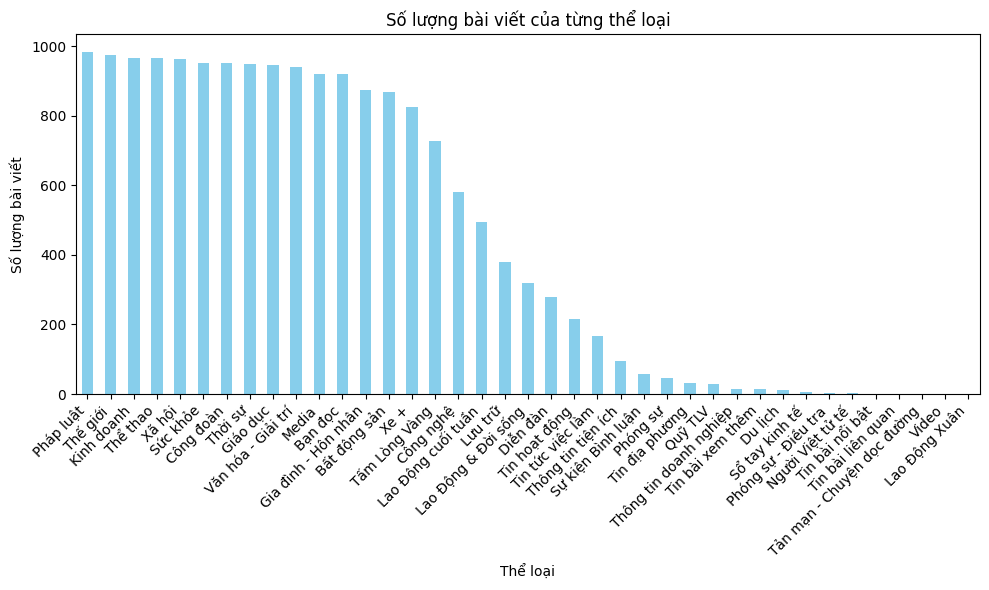

In [ ]:
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng bài viết của từng thể loại')
plt.xlabel('Thể loại')
plt.ylabel('Số lượng bài viết')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x nếu cần
plt.tight_layout()
plt.show()

In [ ]:

category_mapping = {
    'Lao Động Xuân': 'Lao Động & Đời sống',
    'Video': 'Media',
    'Tản mạn - Chuyện dọc đường': 'Bạn đọc',
    'Phóng sự - Điều tra': 'Thời sự',
    'Thông tin doanh nghiệp': 'Kinh doanh',
    'Lao Động cuối tuần': 'Lao Động & Đời sống',
    'Người Việt tử tế': 'Tấm Lòng Vàng',
    'Sổ tay kinh tế': 'Kinh doanh',
    'Quỹ TLV': 'Tấm Lòng Vàng',
    'Tin địa phương': 'Thời sự',
    'Du lịch': 'Văn hóa - Giải trí',
    'Phóng sự': 'Thời sự'
}


# Áp dụng việc thay đổi nhãn
data['Category'] = data['Category'].replace(category_mapping)
data['Category'].value_counts()

Thời sự                1028
Kinh doanh              988
Pháp luật               985
Thế giới                975
Thể thao                965
Xã hội                  964
Sức khỏe                952
Văn hóa - Giải trí      952
Công đoàn               951
Giáo dục                945
Media                   922
Bạn đọc                 921
Gia đình - Hôn nhân     873
Bất động sản            869
Xe +                    826
Lao Động & Đời sống     815
Tấm Lòng Vàng           757
Công nghệ               582
Lưu trữ                 379
Diễn đàn                278
Tin hoạt động           216
Tin tức việc làm        166
Thông tin tiện ích       96
Sự kiện Bình luận        58
Tin bài xem thêm         13
Tin bài liên quan         1
Tin bài nổi bật           1
Name: Category, dtype: int64

In [ ]:
data.drop(data[data['Category'] == 'Lưu trữ'].index,inplace= True)
data.drop(data[data['Category'] == 'Tin hoạt động'].index,inplace= True)
data.drop(data[data['Category'] == 'Diễn đàn'].index,inplace= True)
data.drop(data[data['Category'] == 'Sự kiện Bình luận'].index,inplace= True)
data.drop(data[data['Category'].isin(['Tin bài nổi bật','Tin bài liên quan','Tin bài xem thêm','Lao Động & Đời sống','Bạn đọc','Media','Công đoàn','Xã hội','Kinh doanh','Thời sự'])].index,inplace= True)
data.reset_index(drop = True, inplace = True)

In [ ]:
num_categories = data['Category'].nunique()
print(f'Số lượng thể loại có trong bộ dữ liệu: {num_categories}')
print('Số lượng bài viết của từng thể loại:')
data['Category'].value_counts()

Số lượng thể loại có trong bộ dữ liệu: 13
Số lượng bài viết của từng thể loại:


Pháp luật              985
Thế giới               975
Thể thao               965
Văn hóa - Giải trí     952
Sức khỏe               952
Giáo dục               945
Gia đình - Hôn nhân    873
Bất động sản           869
Xe +                   826
Tấm Lòng Vàng          757
Công nghệ              582
Tin tức việc làm       166
Thông tin tiện ích      96
Name: Category, dtype: int64

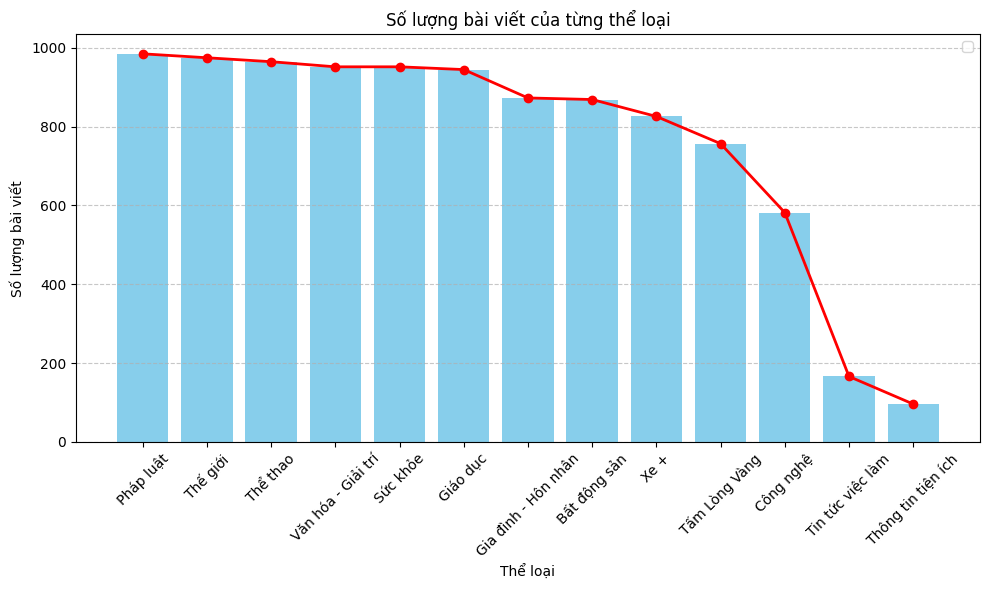

In [ ]:
import matplotlib.pyplot as plt

# Tính toán số lượng bài viết của mỗi thể loại
category_counts = data['Category'].value_counts()

import matplotlib.pyplot as plt

# Tính toán số lượng bài viết của mỗi thể loại
category_counts = data['Category'].value_counts()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(category_counts.index, category_counts.values, marker='o', color='red', linewidth=2)
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.title('Số lượng bài viết của từng thể loại')
plt.xlabel('Thể loại')
plt.ylabel('Số lượng bài viết')
plt.xticks(rotation=45)
plt.legend()  # Hiển thị chú thích
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
data_df = data[['Category','Summary']]
data_df

,Category,Summary
0,Bất động sản,"Bước sang quý III.2019, giao dịch bất động sản..."
1,Bất động sản,Tin tưởng vào việc hùn vốn với giám đốc công t...
2,Bất động sản,Chủ tịch UBND tỉnh Bắc Ninh vừa phê duyệt quy ...
3,Bất động sản,Chuyển đổi quyền sử dụng đất (đổi đất) chỉ áp ...
4,Bất động sản,Không ai phủ nhận ý nghĩa của Đề án giãn dân p...
...,...,...
9938,Xe +,"Mới đây, trên mạng xã hội giao thông đăng tải ..."
9939,Xe +,"Theo thống kê của Uỷ ban ATGT Quốc gia, trong ..."
9940,Xe +,Ca sĩ Lily Chen tậu xe Mercedes G63 AMG có giá...
9941,Xe +,"Xe máy sau một thời gian vận hành, một số bộ p..."


In [ ]:
def text_preprocessing(sent):
    sent = str(sent)

    with open('/content/drive/MyDrive/data/News/data VN/vietnamese.txt', 'r', encoding='utf-8') as f:
        stop_words = f.read().split('\n')

    sent = re.sub(f'[{string.punctuation}\d\n]', '', sent)
    sent = re.sub(r'[^\w\s]', '', sent)
    sent = ViTokenizer.tokenize(sent.lower())
    sent = [w for w in sent.split()]
    sent = [w for w in sent if w not in stop_words]
    return ' '.join(sent)

In [ ]:
data_df['tokenized_contents'] = data['Summary'].apply(lambda x: text_preprocessing(x))
data_df

,Category,Summary,tokenized_contents
0,Bất động sản,"Bước sang quý III.2019, giao dịch bất động sản...",quý iii giao_dịch bất_động_sản thị_trường đà_n...
1,Bất động sản,Tin tưởng vào việc hùn vốn với giám đốc công t...,tin_tưởng hùn vốn giám_đốc công_ty bất_động_sả...
2,Bất động sản,Chủ tịch UBND tỉnh Bắc Ninh vừa phê duyệt quy ...,chủ_tịch ubnd tỉnh bắc ninh phê_duyệt quy_hoạc...
3,Bất động sản,Chuyển đổi quyền sử dụng đất (đổi đất) chỉ áp ...,chuyển_đổi quyền sử_dụng đất đổi đất áp_dụng đ...
4,Bất động sản,Không ai phủ nhận ý nghĩa của Đề án giãn dân p...,phủ_nhận ý_nghĩa đề_án giãn dân_phố cổ hà_nội ...
...,...,...,...
9938,Xe +,"Mới đây, trên mạng xã hội giao thông đăng tải ...",mới_đây mạng xã_hội giao_thông đăng_tải clip b...
9939,Xe +,"Theo thống kê của Uỷ ban ATGT Quốc gia, trong ...",thống_kê uỷ_ban atgt quốc_gia đầu toàn_quốc xả...
9940,Xe +,Ca sĩ Lily Chen tậu xe Mercedes G63 AMG có giá...,ca_sĩ lily chen tậu xe mercedes g amg có_giá l...
9941,Xe +,"Xe máy sau một thời gian vận hành, một số bộ p...",xe_máy thời_gian vận_hành một_số bộ_phận rơ rã...


In [ ]:
# Chia thành cột tokenized_contents và cột Category
lstm_train_data = data_df
sentences = lstm_train_data['tokenized_contents'].tolist()
labels = lstm_train_data['Category'].tolist()
lstm_train_data['Category'].unique()

array(['Bất động sản', 'Công nghệ', 'Văn hóa - Giải trí',
       'Gia đình - Hôn nhân', 'Giáo dục', 'Tấm Lòng Vàng', 'Pháp luật',
       'Sức khỏe', 'Thông tin tiện ích', 'Thế giới', 'Thể thao',
       'Tin tức việc làm', 'Xe +'], dtype=object)

In [ ]:
# Sử dụng LabelEncoder để mã hóa nhãn
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded

array([ 0,  0,  0, ..., 12, 12, 12])

In [ ]:
# Xử lý dữ liệu văn bản
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)
sequences[:1]

[[501,
  2623,
  94,
  47,
  75,
  2,
  51,
  34,
  5,
  364,
  398,
  1044,
  1716,
  14,
  78,
  14,
  123,
  793,
  211,
  953,
  706,
  588,
  266,
  208,
  34,
  5]]

In [ ]:
# Chia thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(sequences, labels_encoded, test_size=0.2, random_state=42)


In [ ]:
# Chuẩn bị nhãn
num_classes = len(label_encoder.classes_)
one_hot_labels_train = to_categorical(y_train, num_classes=num_classes)
one_hot_labels_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# Xử lý dữ liệu đầu vào
max_length = max(len(seq) for seq in sequences)
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
X_train

array([[   0,    0,    0, ...,  201,    8,    4],
       [   0,    0,    0, ...,  996,  708,  340],
       [   0,    0,    0, ..., 1102,  481,    5],
       ...,
       [   0,    0,    0, ..., 6316, 6317, 6318],
       [   0,    0,    0, ...,  150,  928,   39],
       [   0,    0,    0, ...,  159, 2924, 3395]], dtype=int32)

In [ ]:
# # ĐỊNH NGHĨA LỚP ATTENTION
# class Attention(tf.keras.layers.Layer):
#     def __init__(self, return_sequences=False):
#         self.return_sequences = return_sequences
#         super(Attention, self).__init__()

#     def build(self, input_shape):
#         self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
#         self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")

#         super(Attention, self).build(input_shape)

#     def call(self, x):
#         e = K.tanh(K.dot(x, self.W) + self.b)
#         a = K.softmax(e, axis=1)

#         if self.return_sequences:
#             return a * x
#         else:
#             return K.sum(a * x, axis=1)

In [ ]:
from keras.layers import Dropout
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))  # Số chiều đầu ra của LSTM cuối cùng
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 215, 100)          828500    
                                                                 
 lstm (LSTM)                 (None, 215, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 215, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 215, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 215, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 215, 32)           12416     
                                                                 
 dropout_2 (Dropout)         (None, 215, 32)           0

In [ ]:
# embedding_dim = 100

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Attention())
# # model.add(Dense(num_classes, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [ ]:
history = model.fit(X_train, one_hot_labels_train, epochs=10, batch_size=32, validation_data=(X_test, one_hot_labels_test))

Epoch 1/10
249/249 [==============================] - 221s 844ms/step - loss: 2.4739 - accuracy: 0.0963 - val_loss: 2.3807 - val_accuracy: 0.1730
Epoch 2/10
249/249 [==============================] - 207s 832ms/step - loss: 1.9324 - accuracy: 0.3066 - val_loss: 1.5253 - val_accuracy: 0.5028
Epoch 3/10
249/249 [==============================] - 208s 836ms/step - loss: 1.2462 - accuracy: 0.6090 - val_loss: 1.1629 - val_accuracy: 0.6596
Epoch 4/10
249/249 [==============================] - 207s 830ms/step - loss: 0.8460 - accuracy: 0.7660 - val_loss: 1.0552 - val_accuracy: 0.7064
Epoch 5/10
249/249 [==============================] - 209s 839ms/step - loss: 0.6359 - accuracy: 0.8401 - val_loss: 0.9684 - val_accuracy: 0.7381
Epoch 6/10
249/249 [==============================] - 206s 826ms/step - loss: 0.4926 - accuracy: 0.8745 - val_loss: 1.0069 - val_accuracy: 0.7235
Epoch 7/10
249/249 [==============================] - 217s 870ms/step - loss: 0.4053 - accuracy: 0.8995 - val_loss: 1.0197 -

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
loss, accuracy = model.evaluate(X_test, one_hot_labels_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

63/63 [==============================] - 28s 441ms/step - loss: 1.2142 - accuracy: 0.7521
Loss: 1.2141704559326172
Accuracy: 0.752136766910553


In [ ]:
from sklearn.metrics import classification_report
# Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(one_hot_labels_test, axis=1)

print(classification_report(y_test, y_pred))

63/63 [==============================] - 17s 269ms/step
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       185
           1       0.62      0.64      0.63       116
           2       0.66      0.63      0.65       180
           3       0.87      0.83      0.85       187
           4       0.79      0.77      0.78       194
           5       0.72      0.72      0.72       194
           6       0.55      0.76      0.64        21
           7       0.67      0.73      0.70       183
           8       0.94      0.81      0.87       187
           9       0.62      0.55      0.58        38
          10       0.72      0.91      0.80       156
          11       0.66      0.68      0.67       196
          12       0.85      0.80      0.82       152

    accuracy                           0.75      1989
   macro avg       0.73      0.74      0.73      1989
weighted avg       0.76      0.75      0.75      1989



In [ ]:
# # Lưu mô hình với encoding UTF-8
# joblib.dump(model, 'lstm_model.joblib')

In [ ]:
stopword_file = '/content/drive/MyDrive/data/News/data VN/vietnamese.txt'

In [ ]:
# Đọc danh sách từ stopword từ tệp
with open(stopword_file, 'r', encoding='utf-8') as f:
    stopword_list = [word.strip() for word in f.readlines()]

In [ ]:
# Chuẩn bị 5 câu test ngẫu nhiên
import random

new_sentences = data['Summary'].tolist()

random_indexes = random.sample(range(len(new_sentences)), 5)
random_sentences = [new_sentences[i] for i in random_indexes]

print("Câu test:", random_sentences)

Câu test: ['Cơ quan Vũ trụ Nga Roscosmos đang hoàn thiện module mới để sử dụng trên Trạm vũ trụ của Nga.', 'Những cơn mưa dông và ngập úng thường gây nên sự hỗn loạn, thậm chí là làm tê liệt toàn bộ hệ thống giao thông nội đô. Ngay cả những tài xế có kinh nghiệm cũng phải lăn tăn khi vượt qua những cung đường ngập nước, đặc biệt là ở những khu vực không quen thuộc. Vậy cần lưu ý\xa0những điều gì khi buộc phải lái xe qua vùng ngập nước?', 'Trong tập 11 phim "Dâu bể đường trần", biết ơn Kim Phan đã cứu con gái mình, ông Đốc Phủ đứng ra bảo chứng cho Kim Phan được vay tiền. Toàn tâm toàn ý lấy lòng Ánh Xuân và cha má cô, Kim Phan không hề hay biết ở nhà mẹ và vợ mình phải chịu nhiều uất ức, cực khổ ra sao.', 'Sau khi kết hôn, vợ chồng trẻ nên thống nhất về kinh tế trong gia đình nhằm tránh những bất đồng quan điểm về sau.', 'Ngày nay, các mô-đun thiết kế máy ảnh ở  các smartphone ngày càng lớn hơn. Cụm Camera Samsung Galaxy S21, Iphone 12... là ví dụ điển hình về điều đó. Nhưng điều đó có

In [ ]:
# Tiền xử lý câu mới
preprocessed_sentences = []
for sentence in random_sentences:
    preprocessed_sentence = re.sub(r'[^\w\s]', '', sentence)  # Loại bỏ dấu câu không cần thiết
    preprocessed_sentence = ViTokenizer.tokenize(preprocessed_sentence)   # Tokenize câu sử dụng ViTokenizer
    words = preprocessed_sentence.split()
    words = [word for word in words if word.lower() not in stopword_list]  # Loại bỏ stopword
    preprocessed_sentence = ' '.join(words)
    preprocessed_sentences.append(preprocessed_sentence)

In [ ]:
# Chuyển đổi câu mới thành chuỗi số
new_sequences_5 = tokenizer.texts_to_sequences(preprocessed_sentences)
new_sequences_5 = pad_sequences(new_sequences_5, maxlen=max_length)



In [ ]:
# Dự đoán nhãn cho 5 câu ngẫu nhiên
predictions_5 = model.predict(new_sequences_5)
predicted_labels_5 = label_encoder.inverse_transform(np.argmax(predictions_5, axis=1))

# In kết quả dự đoán cho 5 câu
for sentence, label in zip(random_sentences, predicted_labels_5):
    print("Câu test:", sentence)
    print("Giá trị dự đoán:", label)
    print()

1/1 [==============================] - 0s 81ms/step
Câu test: Có 14 trong số 31 tỉnh và vùng của Trung Quốc ghi nhận các ca nhập khẩu nhiễm biến thể Omicron, cơ quan y tế quốc gia thông tin.
Giá trị dự đoán: Sức khỏe

Câu test: Sau những kỳ tích về xây dựng nhà máy, phát triển sản phẩm, VinFast đang thực hiện những chính sách chưa từng có tiền lệ cả về bán hàng và sau bán hàng, giúp khách hàng an tâm, tin tưởng từ khi mua cho đến suốt quá trình sử dụng xe sau này.
Giá trị dự đoán: Xe +

Câu test: Dù gặp nhiều ồn ào nhưng năm 2021 được xem là năm bội thu với Tiêu Chiến khi anh có nhiều cột mốc lẫn phim  đã và sắp phát sóng.
Giá trị dự đoán: Văn hóa - Giải trí

Câu test: Mới đây, hai mẹ con Quách Tuấn Du lần đầu cùng trải lòng về mọi khó khăn từng trải qua trong cuộc sống. Trong đó, câu chuyện nam ca sĩ từng suýt chết hụt 3 lần và lời hối hận vì từng cản mẹ đi bước nữa khiến người hâm mộ xúc động.
Giá trị dự đoán: Gia đình - Hôn nhân

Câu test: Viện Kiểm sát nhân dân tỉnh Hà Tĩnh đã ra Q

In [ ]:

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
batch_size = 32
epochs = 1

train_times = []  # Lưu trữ thời gian huấn luyện

for i in range(10):
    start_time = time.time()
    history = model.fit(X_train, one_hot_labels_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, one_hot_labels_test))
    end_time = time.time()
    train_time = end_time - start_time
    train_times.append(train_time)
    print(f"Completed training {i + 1} time(s). Training time: {train_time:.2f}s")

249/249 [==============================] - 208s 837ms/step - loss: 0.1968 - accuracy: 0.9557 - val_loss: 1.0559 - val_accuracy: 0.7547
Completed training 1 time(s). Training time: 262.01s
249/249 [==============================] - 206s 829ms/step - loss: 0.1777 - accuracy: 0.9612 - val_loss: 1.0797 - val_accuracy: 0.7582
Completed training 2 time(s). Training time: 206.21s
249/249 [==============================] - 206s 827ms/step - loss: 0.1570 - accuracy: 0.9663 - val_loss: 1.1310 - val_accuracy: 0.7481
Completed training 3 time(s). Training time: 205.95s
249/249 [==============================] - 208s 838ms/step - loss: 0.1384 - accuracy: 0.9705 - val_loss: 1.1479 - val_accuracy: 0.7531
Completed training 4 time(s). Training time: 262.01s
249/249 [==============================] - 209s 838ms/step - loss: 0.1490 - accuracy: 0.9661 - val_loss: 1.1448 - val_accuracy: 0.7562
Completed training 5 time(s). Training time: 208.62s
249/249 [==============================] - 206s 827ms/step -

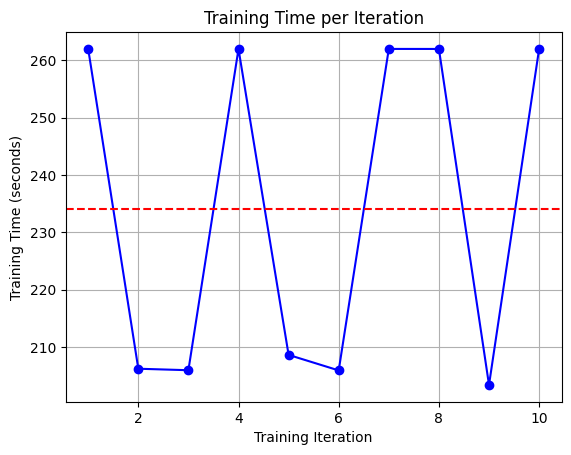

In [ ]:
# Vẽ đồ thị thời gian huấn luyện
plt.plot(range(1, 11, 1), train_times, marker='o', linestyle='-', color='blue')
plt.axhline(y=np.mean(train_times), color='red', linestyle='--')
plt.xlabel('Training Iteration')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time per Iteration')
plt.grid(True)
plt.show()


63/63 [==============================] - 13s 203ms/step


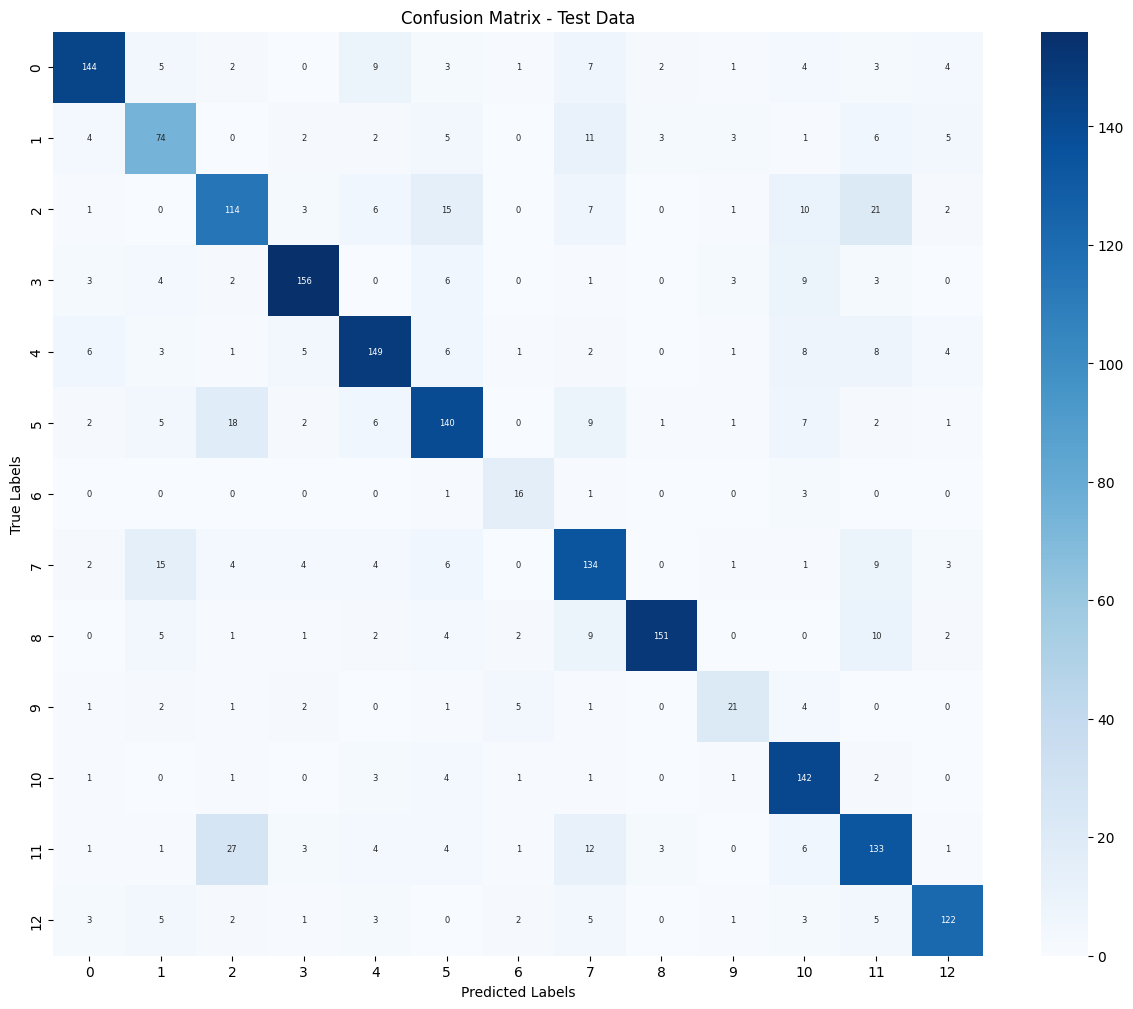

In [ ]:
# Biểu diễn trực quan mô hình (Dự đoán - Thực tế)

# Dự đoán nhãn trên tập kiểm tra
test_predictions = model.predict(X_test)
test_predicted_labels = label_encoder.inverse_transform(np.argmax(test_predictions, axis=1))

# Tính toán ma trận nhầm lẫn trên tập kiểm tra
test_cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(one_hot_labels_test, axis=1)), test_predicted_labels)

# Trực quan hóa ma trận nhầm lẫn trên tập kiểm tra
plt.figure(figsize=(15, 12))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 6})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()